In [2]:

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from third_party.gmm_torch.gmm import GaussianMixture
from card_1_lib import real_world, visualize_gmm

### In this notebook we're going to be dealing with information sharing, so we will need a better definition of our explorer agents

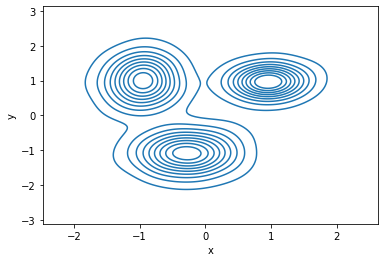

In [18]:
class Explorer:
    """
    A class used to represent our explorers. 
    Attributes:
    environment : GaussianMixture
        The environment the explorer samples from
    model : GaussianMixture
        The internal model the explorer has of its environment
    experiences : Tensor
        A buffer containing samples from the environment.
    """
    def __init__(
        self,
        environment: GaussianMixture = real_world,
        model: GaussianMixture = GaussianMixture(3, 2, covariance_type="diag"),
    ) -> None:
        """Initializes the explorer with a given environment and internal model"""
        self.environment = environment
        self.model = model
        self.experiences = torch.empty(0, 2)
    
    def sample(self, n: int) -> None:
        """Draws n samples from the environment, and adds them to experience buffer"""
        samples, _ = self.environment.sample(n)
        self.experiences = torch.cat([self.experiences, samples])
    
    def fit(self) -> None:
        """Fits internal model to experiences"""
        self.model.fit(self.experiences)
    
    def display(self) -> None:
        """Displays GMM"""
        visualize_gmm(self.model)


explorer_1 = Explorer()
explorer_1.sample(30)
explorer_1.fit()
explorer_1.display()